# Baseline method

In this notebook we train a basic shallow neural network (SNN) to predict fatigue rates based on `10-min` stats of accelerations to serve as a baseline for the autoencoder method.

## Data loading

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 


In [4]:
db_path = Path(settings.path.processed, 'norther.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

In [5]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Collect fleet leaders
fleet_leader_list = ", ".join([f"'{t}'" for t in settings.norther.fleet_leader])

# Step 1: Fetch column metadata from the scada table
query_columns = "PRAGMA table_info(scada)"  # Retrieves metadata about the table
columns_info = pd.read_sql_query(query_columns, conn)

# Step 2: Filter columns containing 'NAC_ACC' (programmatic filtering in Python)
filtered_columns = columns_info[columns_info['name'].str.contains('NAC_ACC')]['name'].tolist()

# Step 3: Use the filtered columns in the SELECT clause dynamically
columns_str = ", ".join([f"s.{col}" for col in filtered_columns])  # Prepare column string for SQL

# Step 4: Construct the final query
query = f"""
SELECT 
    p.timestamp, 
    p.turbine_name, 
    {columns_str},
    s.DEM5_TP_SG_LAT014_Mtn
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE
    p.turbine_name IN ({fleet_leader_list})
"""

# Execute the query
merged_data = pd.read_sql_query(query, conn)
merged_data.dropna(how='all',axis=1,inplace=True)
merged_data.dropna(inplace=True)

In [6]:
train_columns = ['mean_NAC_ACC_Z',
 'min_NAC_ACC_Z',
 'max_NAC_ACC_Z',
 'rms_NAC_ACC_Z',
 'rms1p_NAC_ACC_Z',
 'mean_NAC_ACC_FA',
 'min_NAC_ACC_FA',
 'max_NAC_ACC_FA',
 'rms_NAC_ACC_FA',
 'rms1p_NAC_ACC_FA',
 'mean_NAC_ACC_SS',
 'min_NAC_ACC_SS',
 'max_NAC_ACC_SS',
 'rms_NAC_ACC_SS',
 'rms1p_NAC_ACC_SS',
 'DEM5_TP_SG_LAT014_Mtn']

In [7]:
fleet_leader_list

"'NRTC01', 'NRTC03', 'NRTH01', 'NRTF03', 'NRTJ03'"

## Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

training_turbines_data = merged_data.query(f"turbine_name in {settings.norther.fleet_leader[:2]}")
feautres = training_turbines_data[train_columns[:-1]].values
target = training_turbines_data['DEM5_TP_SG_LAT014_Mtn']
X_train, X_test, y_train, y_test = train_test_split(feautres, target, test_size=0.10, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"R2: {r2_score(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}") 

# all turbine data
merged_data['dem5_pred'] = rf.predict(merged_data[train_columns[:-1]].values)


R2: 0.7350956879074699
MAE: 265875.02012380474


In [9]:
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])
merged_data.sort_values(by='timestamp', inplace=True)

In [10]:
merged_data['turbine_name'].unique()

array(['NRTH01', 'NRTC03', 'NRTF03', 'NRTJ03', 'NRTC01'], dtype=object)

(np.float64(19723.0), np.float64(19736.0))

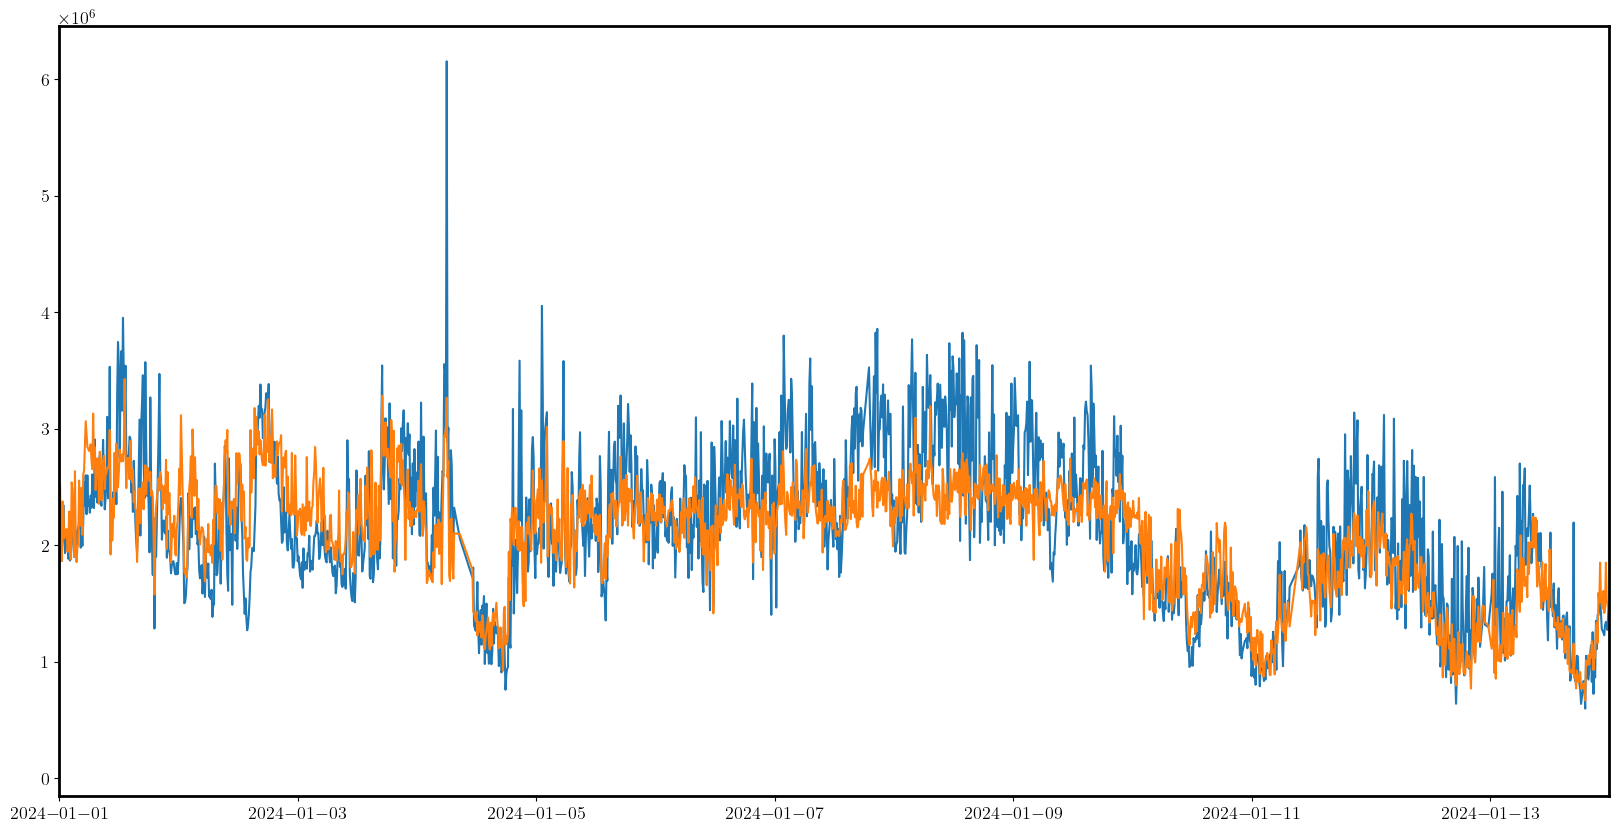

In [11]:
plt.figure(figsize=(20,10))
df_turb = merged_data.query("turbine_name == 'NRTH01'")
plt.plot(df_turb['timestamp'], df_turb['DEM5_TP_SG_LAT014_Mtn'])
plt.plot(df_turb['timestamp'], df_turb['dem5_pred'])
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-01-14')
plt.xlim(start_date, end_date)

In [12]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics_scada = get_statistic(db_path,train_columns,
              [np.max,np.min,np.std,np.mean], 'scada',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics_scada.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics_scada)



Query: SELECT mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, DEM5_TP_SG_LAT014_Mtn FROM scada WHERE timestamp > '2023-01-01' AND timestamp < '2024-01-01'


                  Statistics Table                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Column Name           ┃ Statistic ┃        Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ mean_NAC_ACC_Z        │ max       │      -0.9915 │
│ mean_NAC_ACC_Z        │ min       │      -1.0130 │
│ mean_NAC_ACC_Z        │ std       │       0.0028 │
│ mean_NAC_ACC_Z        │ mean      │      -0.9952 │
│ min_NAC_ACC_Z         │ max       │      -0.9940 │
│ min_NAC_ACC_Z         │ min       │      -1.0387 │
│ min_NAC_ACC_Z         │ std       │       0.0037 │
│ min_NAC_ACC_Z         │ mean      │      -1.0001 │
│ max_NAC_ACC_Z         │ max       │      -0.8118 │
│ max_NAC_ACC_Z         │ min       │      -1.0124 │
│ max_NAC_ACC_Z         │ std       │       0.0044 │
│ max_NAC_ACC_Z         │ mean      │      -0.9903 │
│ rms_NAC_ACC_Z         │ max       │       0.0033 │
│ rms_NAC_ACC_Z         │ min       │       0.0001 │
│ rms_NAC_ACC_Z         │ std       │       0.0006 │
│ rms_NAC_ACC_Z         │ mean      │       0.0011 │
│ rms1p_NAC_ACC_Z       │ max       │       0.0014 │
│ rms1p_NAC_ACC_Z       │ min       │       0.0000 │
│ rms1p_NAC_ACC_Z       │ std       │       0.0001 │
│ rms1p_NAC_ACC_Z       │ mean      │       0.0001 │
│ mean_NAC_ACC_FA       │ max       │       0.0000 │
│ mean_NAC_ACC_FA       │ min       │       0.0000 │
│ mean_NAC_ACC_FA       │ std       │       0.0000 │
│ mean_NAC_ACC_FA       │ mean      │       0.0000 │
│ min_NAC_ACC_FA        │ max       │      -0.0013 │
│ min_NAC_ACC_FA        │ min       │      -0.1071 │
│ min_NAC_ACC_FA        │ std       │       0.0138 │
│ min_NAC_ACC_FA        │ mean      │      -0.0270 │
│ max_NAC_ACC_FA        │ max       │       0.1185 │
│ max_NAC_ACC_FA        │ min       │       0.0013 │
│ max_NAC_ACC_FA        │ std       │       0.0135 │
│ max_NAC_ACC_FA        │ mean      │       0.0266 │
│ rms_NAC_ACC_FA        │ max       │       0.0346 │
│ rms_NAC_ACC_FA        │ min       │       0.0004 │
│ rms_NAC_ACC_FA        │ std       │       0.0032 │
│ rms_NAC_ACC_FA        │ mean      │       0.0068 │
│ rms1p_NAC_ACC_FA      │ max       │       0.0113 │
│ rms1p_NAC_ACC_FA      │ min       │       0.0000 │
│ rms1p_NAC_ACC_FA      │ std       │       0.0013 │
│ rms1p_NAC_ACC_FA      │ mean      │       0.0012 │
│ mean_NAC_ACC_SS       │ max       │       0.0000 │
│ mean_NAC_ACC_SS       │ min       │       0.0000 │
│ mean_NAC_ACC_SS       │ std       │       0.0000 │
│ mean_NAC_ACC_SS       │ mean      │       0.0000 │
│ min_NAC_ACC_SS        │ max       │      -0.0016 │
│ min_NAC_ACC_SS        │ min       │      -0.0978 │
│ min_NAC_ACC_SS        │ std       │       0.0113 │
│ min_NAC_ACC_SS        │ mean      │      -0.0218 │
│ max_NAC_ACC_SS        │ max       │       0.0959 │
│ max_NAC_ACC_SS        │ min       │       0.0016 │
│ max_NAC_ACC_SS        │ std       │       0.0114 │
│ max_NAC_ACC_SS        │ mean      │       0.0220 │
│ rms_NAC_ACC_SS        │ max       │       0.0234 │
│ rms_NAC_ACC_SS        │ min       │       0.0005 │
│ rms_NAC_ACC_SS        │ std       │       0.0034 │
│ rms_NAC_ACC_SS        │ mean      │       0.0065 │
│ rms1p_NAC_ACC_SS      │ max       │       0.0065 │
│ rms1p_NAC_ACC_SS      │ min       │       0.0000 │
│ rms1p_NAC_ACC_SS      │ std       │       0.0010 │
│ rms1p_NAC_ACC_SS      │ mean      │       0.0009 │
│ DEM5_TP_SG_LAT014_Mtn │ max       │ 5475700.2678 │
│ DEM5_TP_SG_LAT014_Mtn │ min       │  107433.0649 │
│ DEM5_TP_SG_LAT014_Mtn │ std       │  743985.8472 │
│ DEM5_TP_SG_LAT014_Mtn │ mean      │ 1401611.8457 │
└───────────────────────┴───────────┴──────────────┘

In [13]:
from src.data import datamodule as dm
from src.model.transformation import ToTensor, EncoderBasedOnList
from src.model.prepared_queries import do_nothing

training_turbines = settings.norther.fleet_leader[:2]
train_transforms = [nn.Identity()] + 15 * [ToTensor()]

# Dynamically build the condition to exclude rows with NULLs
non_null_conditions = " AND ".join([f"{col} IS NOT NULL" for col in train_columns])

# Create the final query with the non-NULL condition
key_query = f"""
SELECT id 
FROM scada
WHERE turbine_name IN ('{"','".join(training_turbines)}')
  AND {non_null_conditions}
"""


data_loader_reg = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing,    # or any custom query that fetches Welch_*, DEM
    view_table_name='scada',
    key_query=key_query,
    key_name='id',
    columns=train_columns,
    transform_func=train_transforms,
    batch_size=64,
    cached=True,
    return_dict=True
)

data_loader_reg.setup()

## Neural Network

### MLP 

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Specify input feature columns and target column
dataframe = merged_data.query(f"turbine_name in {settings.norther.fleet_leader[:2]}")
input_columns = dataframe[train_columns[:-1]]
target_column = dataframe['DEM5_TP_SG_LAT014_Mtn']

X_train, X_test, y_train, y_test = train_test_split(input_columns, target_column, test_size=0.10, random_state=42)

# Normalize input features but not the target
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convert training and testing data to tensors
x_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Ensure target is 2D
x_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for batching
dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Model parameters
input_size = x_train_tensor.shape[1]  # Dynamically set input size based on data
hidden_size1 = 32
hidden_size2 = 128
hidden_size3 = 64
output_size = 1

# Define the more complex MLP model
class ComplexMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(ComplexMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size3, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model, loss function, and optimizer
model = ComplexMLP(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    for batch_x, batch_y in dataloader:
        # Forward pass
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 115626639360.0000
Epoch [20/100], Loss: 347992064000.0000
Epoch [30/100], Loss: 16307403776.0000
Epoch [40/100], Loss: 247485677568.0000
Epoch [50/100], Loss: 90087530496.0000
Epoch [60/100], Loss: 559522512896.0000
Epoch [70/100], Loss: 110012735488.0000
Epoch [80/100], Loss: 20126644224.0000
Epoch [90/100], Loss: 369016143872.0000
Epoch [100/100], Loss: 330755670016.0000


In [15]:
# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(x_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 208071360512.0000


In [16]:
df_test = dataframe.loc[y_test.index]
df_test['preds'] = predictions

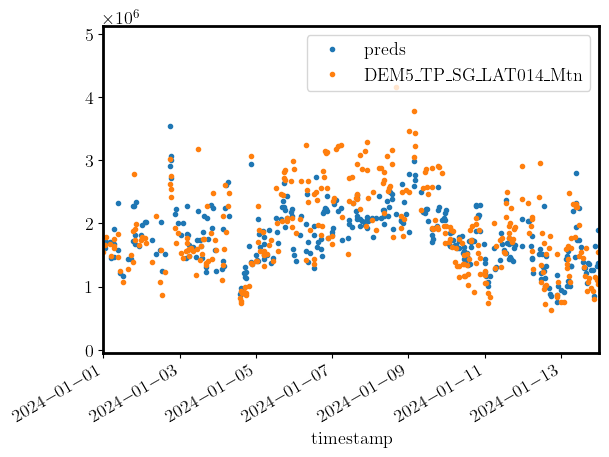

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_test.plot('timestamp','preds',ax=ax,marker='.',ls='')
df_test.plot('timestamp','DEM5_TP_SG_LAT014_Mtn',ax=ax,marker='.',ls='')
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-01-14')
plt.xlim(start_date, end_date)
plt.show()

In [18]:
# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(torch.tensor(scaler.transform(merged_data[train_columns[:-1]]), dtype=torch.float32))

In [19]:
merged_data['pred_nn'] = predictions

# Autoencoder

In [20]:
from src.model.prepared_queries import simple_view, do_nothing
from src.model.transformation import EncoderBasedOnList
columns = ["Welch_X", "Welch_Y", "Welch_Z"]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]*3
freq_axis_masked = transform_func[0][1].freq_axis_masked
transform_func[0]
key_query  = f"""SELECT id FROM processed_data 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'


"""


data_loader = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing, 
    view_table_name='processed_data',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=128,
    cached=True,
    return_dict=True
)
data_loader.setup()

In [21]:
from src.model.backbone.AE import TrainingMultiHeadAE
best_ae_path = Path('/home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints/vae-epoch=26-val_loss=0.74-v4.ckpt')
model_ae =TrainingMultiHeadAE.load_from_checkpoint(best_ae_path)


In [22]:
Path('/home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints/vae-epoch=149-val_loss=0.96.ckpt')

PosixPath('/home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints/vae-epoch=149-val_loss=0.96.ckpt')

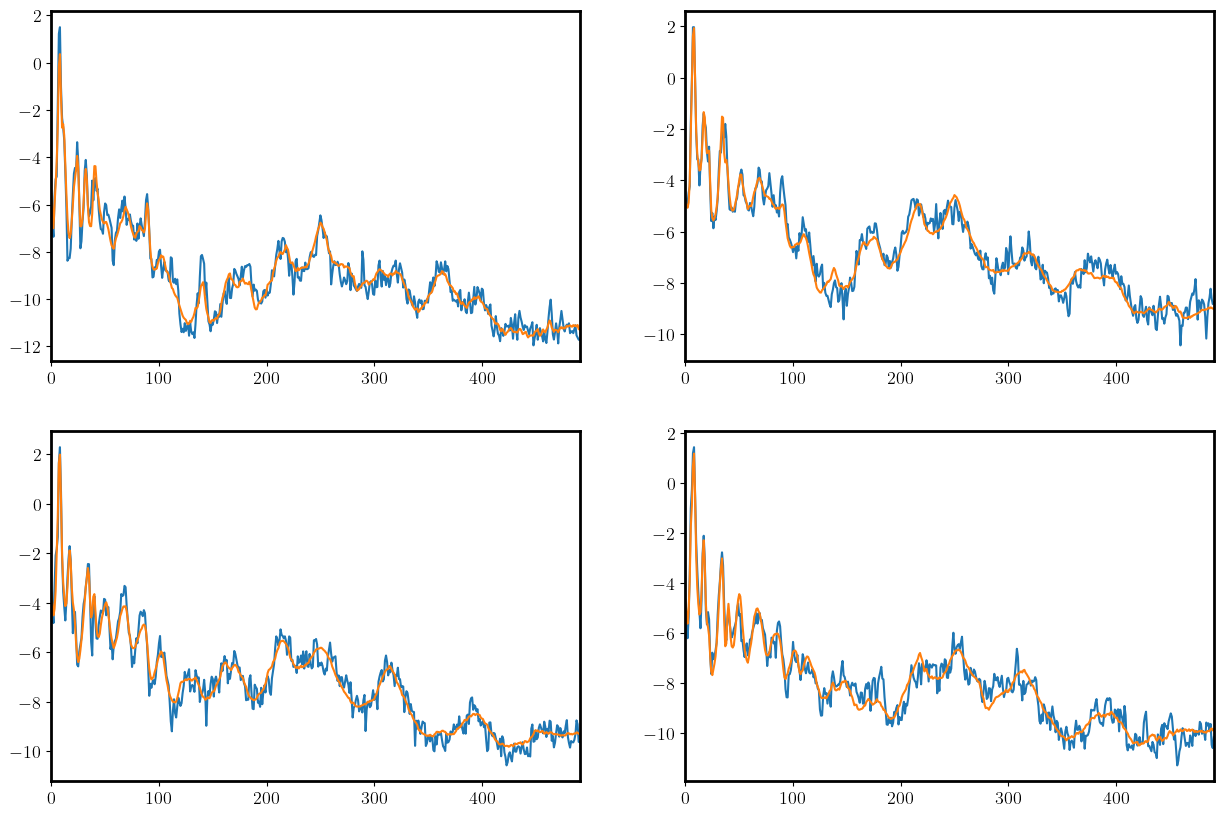

In [23]:
model_ae.to('cpu')
data = next(iter(data_loader.train_dataloader()))

data_rec = model_ae(data) 
data = data['Welch_X']
data_rec = data_rec['reconstruction']['Welch_X']
fig,ax  = plt.subplots(2,2,figsize=(15,10))
for i,(psd_in, psd_out) in enumerate(zip(data[0:4], data_rec[0:4])):
    ax[i//2, i%2].plot( psd_in.cpu().numpy())
    ax[i//2, i%2].plot( psd_out.cpu().detach().numpy())
plt.show()


In [24]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all, welch_all_scada_wo_dem
columns = ['Welch_X','Welch_Y','Welch_Z','mean_windspeed','mean_power','mean_pitch','mean_rpm','caseID','turbine_name','timestamp','DEM']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]+4*[ToTensor()]+ 4*[nn.Identity()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=4096,
    cached=True,
    return_dict=True
)
data_loader_dem.setup() 

In [25]:
dfs = []
for batch in data_loader_dem.train_dataloader():
    with torch.no_grad():
        data = model_ae(batch)
    df_temp = pd.DataFrame({'embedding' : [e for e in data['latent_layer'].cpu().numpy()],
                            'turbine_name': batch['turbine_name'],
                            'timestamp': batch['timestamp'],
                            'DEM': batch['DEM'].cpu().numpy()})
    dfs.append(df_temp)


In [26]:
df_emb_dem = pd.concat(dfs)

In [ ]:
# train a random forest on the embedding to predict the DEM using only the 2 first turbines
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df_emb_dem_train = df_emb_dem.query(f'turbine_name in {fleet_leaders[:2]}')
X = np.stack(df_emb_dem_train['embedding'].values)
y = df_emb_dem_train['DEM'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)

np.float64(70155895765.79715)

In [28]:
df_emb_dem['pred_dem'] = rf.predict(np.stack(df_emb_dem['embedding'].values))

In [29]:
df_emb_dem['timestamp']= pd.to_datetime(df_emb_dem['timestamp'])
df_emb_dem.sort_values('timestamp', inplace=True)

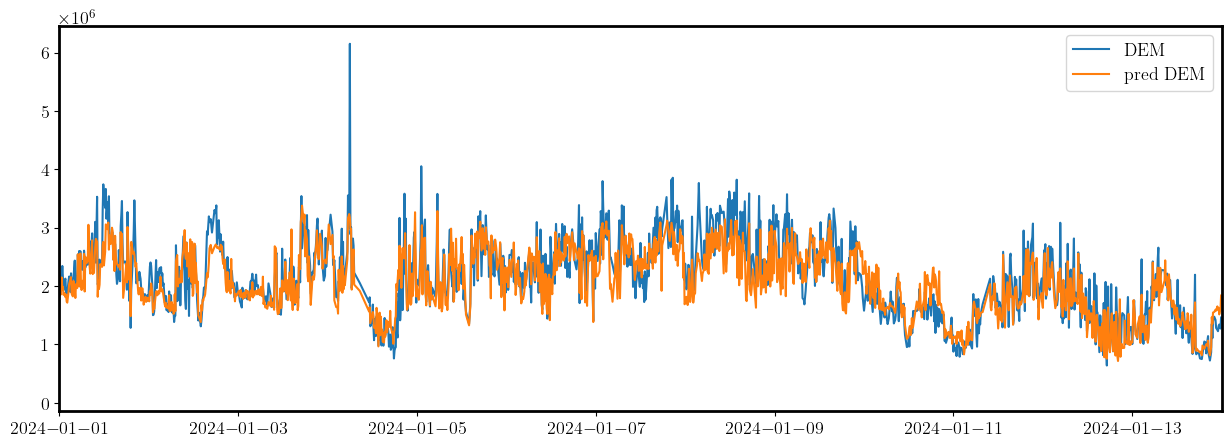

In [30]:
df_emb_dem_turb = df_emb_dem[df_emb_dem['turbine_name']=='NRTH01']
fig,ax= plt.subplots(1,1,figsize=(15,5))
start_time = pd.to_datetime('2024-01-01')
end_time = pd.to_datetime('2024-01-14')
ax.plot(df_emb_dem_turb['timestamp'], df_emb_dem_turb['DEM'], label='DEM')
ax.plot(df_emb_dem_turb['timestamp'], df_emb_dem_turb['pred_dem'], label='pred DEM')
ax.set_xlim(start_time, end_time)
ax.legend()
plt.show()

In [31]:
df_emb_dem

,embedding,turbine_name,timestamp,DEM,pred_dem
3952,"[-0.051547896, -0.35497275, 0.50423247, -0.226...",NRTJ03,2023-01-05 21:00:00+00:00,2.774476e+06,2.220443e+06
2942,"[0.48137158, -0.43800882, 0.5186659, 0.0861571...",NRTC03,2023-01-05 21:00:00+00:00,1.223089e+06,1.328463e+06
184,"[0.18638748, -0.3490153, 0.46718, -0.13573265,...",NRTC01,2023-01-05 21:00:00+00:00,1.802231e+06,1.780659e+06
2728,"[-0.16008827, -0.47761542, 0.5058548, -0.27827...",NRTJ03,2023-01-05 21:10:00+00:00,3.094641e+06,2.325987e+06
2451,"[-0.280381, -0.12043883, 0.50262195, -0.433623...",NRTH01,2023-01-05 21:10:00+00:00,1.627954e+06,2.103012e+06
...,...,...,...,...,...
302,"[0.1041773, 0.19836636, 0.16677071, 0.21815467...",NRTH01,2024-01-13 23:50:00+00:00,1.460177e+06,1.837840e+06
3654,"[-0.050221357, 0.5455309, -0.101897106, 0.1915...",NRTF03,2024-01-13 23:50:00+00:00,1.466556e+06,1.550787e+06
4024,"[0.078062885, -0.04771289, 0.9041643, -0.13714...",NRTC03,2024-01-13 23:50:00+00:00,1.081163e+06,1.179294e+06
233,"[0.07011215, -0.01055681, 0.76129764, -0.05203...",NRTC01,2024-01-13 23:50:00+00:00,1.442068e+06,1.455439e+06


In [32]:
result = merged_data.merge(df_emb_dem, on=['turbine_name', 'timestamp'], how='left')

# Comparison

/tmp/ipykernel_1753865/1659950609.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''])


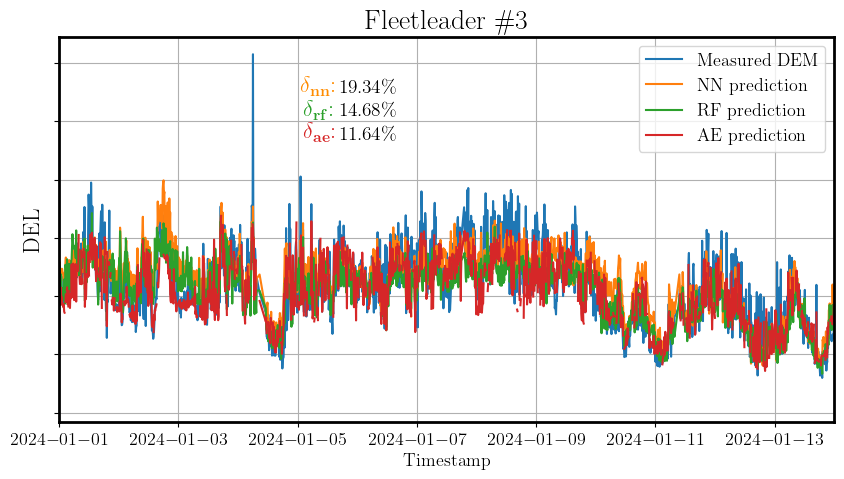

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from src.evaluation.metric import r2_score, relative_err

# Ensure the timestamp column is in datetime format
result['timestamp'] = pd.to_datetime(result['timestamp'])
result.sort_values(by='timestamp', inplace=True)
df_turb = result[result['turbine_name'] == 'NRTH01']

# Define the x-axis limits as datetime objects
start_date = pd.Timestamp('2024-01-01').tz_localize('UTC')
end_date = pd.Timestamp('2024-01-14').tz_localize('UTC')

# Plot the data
fig, ax  = plt.subplots(figsize=(10, 5))
plt.plot(df_turb['timestamp'], df_turb['DEM5_TP_SG_LAT014_Mtn'], label='Measured DEM')
plt.plot(df_turb['timestamp'], df_turb['pred_nn'], label='NN prediction')
plt.plot(df_turb['timestamp'], df_turb['dem5_pred'], label='RF prediction')
plt.plot(df_turb['timestamp'], df_turb['pred_dem'], label='AE prediction')
ax.set_yticklabels([''])
plt.xlim(start_date, end_date)  # Use datetime objects for limits
plt.xlabel('Timestamp')
plt.ylabel('DEL',fontsize=17)
plt.title('Fleetleader \#3', fontsize=20)

# Annotate relative error (NN) for the period
rel_error_nn = merged_data.query("turbine_name == 'NRTH01' and timestamp >= @start_date and timestamp <= @end_date").apply(
    lambda x: relative_err(x['DEM5_TP_SG_LAT014_Mtn'], x['pred_nn']),axis=1).mean()
ax.text(end_date-datetime.timedelta(days=8.35), 5.5*10**6, 
        r'$\mathbf{\delta_{nn}}$:', weight='bold', color='darkorange', fontsize=16, ha='right')
ax.text(end_date-datetime.timedelta(days=7.3), 5.5*10**6, 
        rf'${100*rel_error_nn:.2f}\%$', color='black', fontsize=14, ha='right')

# Annotate relative error (RF) for the period
rel_error_rf = merged_data.query("turbine_name == 'NRTH01' and timestamp >= @start_date and timestamp <= @end_date").apply(
    lambda x: relative_err(x['DEM5_TP_SG_LAT014_Mtn'], x['dem5_pred']),axis=1).mean()
ax.text(end_date-datetime.timedelta(days=8.4), 5.1*10**6, 
        r'$\mathbf{\delta_{rf}}$:', weight='bold', color='tab:green', fontsize=16, ha='right')
ax.text(end_date-datetime.timedelta(days=7.3), 5.1*10**6, 
        rf'${100*rel_error_rf:.2f}\%$', color='black', fontsize=14, ha='right')

# Annotate relative error (AE) for the period
rel_error_ae = result.query("turbine_name == 'NRTH01' and timestamp >= @start_date and timestamp <= @end_date").apply(
    lambda x: relative_err(x['DEM5_TP_SG_LAT014_Mtn'], x['pred_dem']),axis=1).mean()
ax.text(end_date-datetime.timedelta(days=8.35), 4.7*10**6, 
        r'$\mathbf{\delta_{ae}}$:', weight='bold', color='tab:red', fontsize=16, ha='right')
ax.text(end_date-datetime.timedelta(days=7.3), 4.7*10**6, 
        rf'${100*rel_error_ae:.2f}\%$', color='black', fontsize=14, ha='right')

plt.legend()
plt.grid(True)
#plt.savefig('prediction_timeseries.png',dpi=300)
plt.show()

In [ ]:
from src.evaluation.metric import r2_score, relative_err
print('NN: \n Relative error:\n',merged_data.groupby('turbine_name').apply(lambda x: relative_err(x['DEM5_TP_SG_LAT014_Mtn'], x['pred_nn'])))
print("R²:\n",merged_data.groupby('turbine_name').apply(lambda x: r2_score(x['DEM5_TP_SG_LAT014_Mtn'], x['pred_nn'])))
print('RF: \n Relative error:\n',merged_data.groupby('turbine_name').apply(lambda x: relative_err(x['DEM5_TP_SG_LAT014_Mtn'], x['dem5_pred'])))
print("R²:\n",merged_data.groupby('turbine_name').apply(lambda x: r2_score(x['DEM5_TP_SG_LAT014_Mtn'], x['dem5_pred'])))
print('AE: \n Relative error:\n',result.dropna().groupby('turbine_name').apply(lambda x: relative_err(x['DEM5_TP_SG_LAT014_Mtn'], x['pred_dem'])))
print("R²:\n",result.dropna().groupby('turbine_name').apply(lambda x: r2_score(x['DEM5_TP_SG_LAT014_Mtn'], x['pred_dem'])))

NN: 
 Relative error:
 turbine_name
NRTC01    0.225372
NRTC03    0.215488
NRTF03    0.449381
NRTH01    0.246970
NRTJ03    0.374523
dtype: float64
R²:
 turbine_name
NRTC01    0.627493
NRTC03    0.624083
NRTF03    0.098161
NRTH01    0.562933
NRTJ03    0.124412
dtype: float64
RF: 
 Relative error:
 turbine_name
NRTC01    0.070483
NRTC03    0.072034
NRTF03    0.221589
NRTH01    0.168115
NRTJ03    0.214182
dtype: float64
R²:
 turbine_name
NRTC01    0.942008
NRTC03    0.941197
NRTF03    0.576234
NRTH01    0.678056
NRTJ03    0.588679
dtype: float64
AE: 
 Relative error:
 turbine_name
NRTC01    0.051943
NRTC03    0.055302
NRTF03    0.171953
NRTH01    0.141789
NRTJ03    0.180871
dtype: float64
R²:
 turbine_name
NRTC01    0.973675
NRTC03    0.962944
NRTF03    0.779595
NRTH01    0.772094
NRTJ03    0.662290
dtype: float64


/tmp/ipykernel_1753865/445486944.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print('NN: \n Relative error:\n',merged_data.groupby('turbine_name').apply(lambda x: relative_err(x['DEM5_TP_SG_LAT014_Mtn'], x['pred_nn'])))
/tmp/ipykernel_1753865/445486944.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print("R²:\n",merged_data.groupby('turbine_name').apply(lambda x: r2_score(x['DEM5_TP_SG_LAT014_Mt